In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, Model, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import mobilenet, mobilenet_v2, ResNet50V2, resnet_v2, vgg19, EfficientNetV2L, ResNet101, resnet, xception, Xception
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Rescaling, GlobalAveragePooling2D, LeakyReLU, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pandas as pd
import random
import cv2

In [ ]:
print("TF:", tf.__version__)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
print("GPUs:", gpus)

SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

TF: 2.10.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]


2025-11-17 01:38:08.510106: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-11-17 01:38:08.513590: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-11-17 01:38:08.516932: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-11-17 01:38:08.520280: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-11-17 01:38:08.572264: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

## Load Data

In [ ]:
TRAIN_IMG_DIR = "data/train_images"
VAL_IMG_DIR = "data/val_images"
TEST_IMG_DIR = "data/test_images"

print("Train imgs:", len(os.listdir(TRAIN_IMG_DIR)))
print("Val imgs:", len(os.listdir(VAL_IMG_DIR)))
print("Test imgs:", len(os.listdir(TEST_IMG_DIR)))

Train imgs: 4017
Val imgs: 709
Test imgs: 1182


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

train_data = pd.read_csv("data/train_data.csv")
val_data = pd.read_csv("data/val_data.csv")

label_cols = ["normal", "bacteria", "virus", "COVID-19"]  # one-hot 欄位
IMG_SIZE = 224
BATCH_SIZE = 32
SEED = 42

print("normal數量：", sum(train_data['normal']==1))
print("bacteria數量：", sum(train_data['bacteria']==1))
print("virus數量：", sum(train_data['virus']==1))
print("COVID-19數量：", sum(train_data['COVID-19']==1))

y_labels = train_data[label_cols].values.argmax(axis=1)

weights = compute_class_weight(class_weight='balanced', classes=np.arange(len(label_cols)), y=y_labels)
weights = np.sqrt(weights)
class_weights = dict(enumerate(weights))
print(class_weights)

normal數量： 1072
bacteria數量： 1888
virus數量： 1018
COVID-19數量： 39
{0: 0.9678844833627246, 1: 0.7293230260119219, 2: 0.9932236021018138, 3: 5.07444578254611}


## Preprocessing

In [ ]:
train_data["new_filename"] = train_data["new_filename"].astype(str)
train_data[label_cols] = train_data[label_cols].astype("float32")
val_data["new_filename"] = val_data["new_filename"].astype(str)
val_data[label_cols] = val_data[label_cols].astype("float32")

train_datagen = ImageDataGenerator(
    preprocessing_function=resnet.preprocess_input,
    rotation_range=10, 
    width_shift_range=0.05, 
    height_shift_range=0.05,
    shear_range=0.05, 
    zoom_range=0.1,
    horizontal_flip=True, fill_mode='nearest'
)
val_datagen = ImageDataGenerator(
    preprocessing_function=resnet.preprocess_input,
)

In [ ]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=TRAIN_IMG_DIR,  
    x_col="new_filename",
    y_col=label_cols,  
    # target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='raw',
    shuffle=True,
    seed=SEED
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_data,
    directory=VAL_IMG_DIR,  
    x_col="new_filename",
    y_col=label_cols,  
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='raw',
    shuffle=False
)

Found 4017 validated image filenames.
Found 709 validated image filenames.


(32, 224, 224, 3) (32, 4) [[1. 0. 0. 0.]
 [0. 0. 1. 0.]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].


(32, 224, 224, 3) (32, 4) [[0. 1. 0. 0.]
 [0. 1. 0. 0.]]


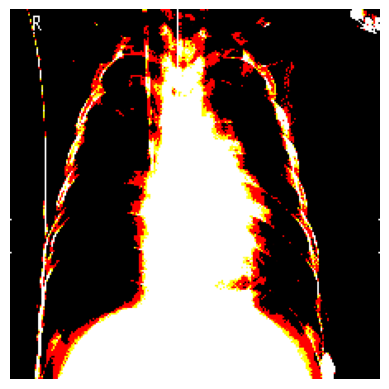

In [ ]:
xb, yb = next(train_generator)
print(xb.shape, yb.shape, yb[:2])
xb2, yb2 = next(val_generator)
print(xb2.shape, yb2.shape, yb2[:2])

import matplotlib.pyplot as plt
plt.imshow(xb2[0])
plt.axis('off') 
plt.show()

## Build Model

In [ ]:
def build_model():
    base = ResNet50(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3), pooling='avg')
    base.trainable = False  # 先凍結整個resnet50
    dropout = 0.4

    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = base(inputs, training=False)        # batchnorm凍結
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(4, activation='softmax', dtype='float32')(x)  

    model = models.Model(inputs, outputs)
    return model

## Training

In [9]:
def get_callbacks(model_name):
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True,
        verbose=1
    )
    
    model_checkpoint = ModelCheckpoint(
        f'{model_name}_best.h5',
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        verbose=1
    )
    
    return [early_stopping, model_checkpoint]


In [ ]:
class MacroF1(tf.keras.metrics.Metric):
    def __init__(self, num_classes, name='f1_macro', **kwargs):
        super().__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.eps = 1e-7
        
        self.tp = self.add_weight(name='tp', shape=(num_classes,), initializer='zeros', dtype=tf.float32)
        self.fp = self.add_weight(name='fp', shape=(num_classes,), initializer='zeros', dtype=tf.float32)
        self.fn = self.add_weight(name='fn', shape=(num_classes,), initializer='zeros', dtype=tf.float32)

    def update_state(self, y_true, y_pred, sample_weight=None):
        
        y_true = tf.argmax(y_true, axis=-1)
        y_pred = tf.argmax(y_pred, axis=-1)

        cm = tf.math.confusion_matrix(y_true, y_pred,
                                      num_classes=self.num_classes,
                                      dtype=tf.float32)  # [C, C]
        tp = tf.linalg.diag_part(cm)
        fp = tf.reduce_sum(cm, axis=0) - tp
        fn = tf.reduce_sum(cm, axis=1) - tp

        self.tp.assign_add(tp)
        self.fp.assign_add(fp)
        self.fn.assign_add(fn)

    def result(self):
        precision = self.tp / (self.tp + self.fp + self.eps)
        recall    = self.tp / (self.tp + self.fn + self.eps)
        f1 = 2.0 * precision * recall / (precision + recall + self.eps)
        return tf.cast(tf.reduce_mean(f1), tf.float32)

    
    def reset_state(self):
        self.tp.assign(tf.zeros_like(self.tp))
        self.fp.assign(tf.zeros_like(self.fp))
        self.fn.assign(tf.zeros_like(self.fn))
    def reset_states(self):
        self.reset_state()


In [12]:
model = build_model()
callbacks = get_callbacks(model_name="resnet50_freeze_batchnorm_final")

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=[MacroF1(num_classes=4, name='f1_macro')]
)

history1 = model.fit(
    train_generator,
    epochs=30, 
    validation_data=val_generator,
    callbacks=callbacks, verbose=1
)

Epoch 1/30


2025-11-17 01:38:18.292247: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8902
2025-11-17 01:38:18.426316: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-11-17 01:38:18.427443: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-11-17 01:38:18.427480: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2025-11-17 01:38:18.428648: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-11-17 01:38:18.428795: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


126/126 [==============================] - ETA: 0s - loss: 1.2533 - f1_macro: 0.4795
Epoch 1: val_loss improved from inf to 0.93706, saving model to resnet50_freeze_batchnorm_final_best.h5
126/126 [==============================] - 105s 799ms/step - loss: 1.2533 - f1_macro: 0.4795 - val_loss: 0.9371 - val_f1_macro: 0.5772
Epoch 2/30
126/126 [==============================] - ETA: 0s - loss: 0.9669 - f1_macro: 0.5405
Epoch 2: val_loss improved from 0.93706 to 0.75962, saving model to resnet50_freeze_batchnorm_final_best.h5
126/126 [==============================] - 98s 781ms/step - loss: 0.9669 - f1_macro: 0.5405 - val_loss: 0.7596 - val_f1_macro: 0.6947
Epoch 3/30
126/126 [==============================] - ETA: 0s - loss: 0.8500 - f1_macro: 0.5863
Epoch 3: val_loss improved from 0.75962 to 0.73610, saving model to resnet50_freeze_batchnorm_final_best.h5
126/126 [==============================] - 100s 788ms/step - loss: 0.8500 - f1_macro: 0.5863 - val_loss: 0.7361 - val_f1_macro: 0.7176

In [ ]:
model = build_model()
base = model.get_layer("resnet50")
for layer in model.layers:
    if isinstance(layer, Model):
        for l in layer.layers:
            # 解凍conv4_和conv5_
            l.trainable = (('conv5_' in l.name) or ('conv4_' in l.name))
            
# 鎖住batchnorm
for layer in base.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False
        
model.compile(
    optimizer=tf.keras.optimizers.Adam(3e-5),
    loss='categorical_crossentropy',
    metrics=[MacroF1(num_classes=4, name='f1_macro')]
)
history2 = model.fit(
    train_generator, 
    epochs=20, 
    validation_data=val_generator,
    callbacks=callbacks, verbose=1
)

Epoch 1/20
126/126 [==============================] - ETA: 0s - loss: 0.4684 - f1_macro: 0.8051
Epoch 1: val_loss did not improve from 0.55360
126/126 [==============================] - 100s 777ms/step - loss: 0.4684 - f1_macro: 0.8051 - val_loss: 0.5621 - val_f1_macro: 0.8352
Epoch 2/20
126/126 [==============================] - ETA: 0s - loss: 0.4611 - f1_macro: 0.7998
Epoch 2: val_loss did not improve from 0.55360
126/126 [==============================] - 98s 776ms/step - loss: 0.4611 - f1_macro: 0.7998 - val_loss: 0.5662 - val_f1_macro: 0.8376
Epoch 3/20
126/126 [==============================] - ETA: 0s - loss: 0.4407 - f1_macro: 0.8209
Epoch 3: val_loss did not improve from 0.55360
126/126 [==============================] - 97s 772ms/step - loss: 0.4407 - f1_macro: 0.8209 - val_loss: 0.5689 - val_f1_macro: 0.8348
Epoch 4/20
126/126 [==============================] - ETA: 0s - loss: 0.4693 - f1_macro: 0.7963
Epoch 4: val_loss did not improve from 0.55360
126/126 [================

# Inference

In [ ]:
from pathlib import Path

pretrained_weight = 'resnet50_freeze_batchnorm_final_best.h5'
output_file = 'submission.csv'

model = build_model()
model = tf.keras.models.load_model(pretrained_weight, compile=False)

h, w = model.input_shape[1], model.input_shape[2]
batch_size = 32
APPLY_RESCALE = True


img_paths = sorted([p for p in Path(TEST_IMG_DIR).glob("**/*") if p.suffix.lower() in {".jpg", ".jpeg", ".png"}])
if not img_paths:
    raise FileNotFoundError(f"No images found under: {TEST_IMG_DIR}")


filenames = [p.name for p in img_paths]


def load_and_preprocess(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, [h, w], method=tf.image.ResizeMethod.BILINEAR)
    if APPLY_RESCALE:
        img = tf.cast(img, tf.float32)
        img = resnet.preprocess_input(img)
    return img

path_ds = tf.data.Dataset.from_tensor_slices([str(p) for p in img_paths])
ds = path_ds.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

probs = model.predict(ds, verbose=1)                  # (N, 4)
# print(probs)
pred_ids = np.argmax(probs, axis=1)                   # (N,)
one_hot = np.eye(len(label_cols), dtype=int)[pred_ids]  # 轉為 one-hot
# print(one_hot)

out_df = pd.DataFrame(one_hot, columns=label_cols)
out_df.insert(0, "new_filename", filenames)
out_df.to_csv(output_file, index=False)

print(f"Done. Wrote {len(out_df)} rows to {output_file}")

37/37 [==============================] - 5s 119ms/step
Done. Wrote 1182 rows to submission.csv
